In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import datasets,transforms

from torch.utils.data import DataLoader,SubsetRandomSampler,sampler
import numpy as np

import matplotlib.colors as mcolors

In [2]:
def get_data_loader_mnist(batch_size,num_workers=0,validation_fraction=0
                          ,train_transforms=None,test_transforms=None):
  if train_transforms is None:
    train_transforms = transforms.ToTensor()
  
  if test_transforms is None:
    test_transforms = transforms.ToTensor()

  
  train_dataset = datasets.MNIST(root='data',train=True,transform=train_transforms,download=True)

  valid_dataset = datasets.MNIST(root='data',train=True,transform=test_transforms)

  test_dataset = datasets.MNIST(root='data',train=False,transform=test_transforms) 


  if validation_fraction is not None:
    num = int(validation_fraction * 60000)

    train_indices = np.arange(0,60000-num)
    val_indices = np.arange(60000-num,60000)

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    valid_loader = DataLoader(dataset = valid_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              sampler=valid_sampler)
    
    train_loader = DataLoader(dataset = train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              drop_last=True,
                              sampler=train_sampler)
    
  else:
    train_loader = DataLoader(dataset = train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)
    
  
  test_loader = DataLoader(dataset = test_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                            shuffle=False)
  
  if validation_fraction is None:
    return train_loader,test_loader

  else:
    return train_loader,valid_loader,test_loader
    
  




In [3]:
train_loader, valid_loader, test_loader = get_data_loader_mnist(
    batch_size=256, 
    num_workers=2, 
    validation_fraction=0.)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
#Checking the dataset
print("Training set:")
for images,labels in train_loader:
  print('Image batch dimensions:', images.size())
  print('Image label dimensions:', labels.size())
  print(labels[:10])
  break


# Checking the dataset
print('Testing Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break


Training set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([1, 7, 1, 6, 0, 9, 3, 4, 1, 2])
Testing Set:
Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


Model

In [29]:
class Reshape(nn.Module):
  def __init__(self,*args):
    super().__init__()
    self.shape=args
  
  def forward(self,x):
    #print(x.shape)
    return x.view(self.shape)


class Trim(nn.Module):
  def __init__(self,*args):
    super().__init__()
  
  def forward(self,x):
    return x[:,:,:28,:28]


class VAE(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1,32,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.Flatten(),
    )

    self.z_mean = nn.Linear(3136,2)
    self.z_log_var = nn.Linear(3136,2)

    self.decoder = nn.Sequential(
        nn.Linear(2,3136),
        Reshape(-1,64,7,7),
        nn.ConvTranspose2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,32,stride=(2,2),kernel_size=(3,3),padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32,1,stride=(1,1),kernel_size=(3,3),padding=0),
        Trim(), # 1 x 29 x 29 -> 1x28x28
        nn.Sigmoid() 
    )

  #Used while plotting latent spaces
  def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
  
  def reparametrize(self, z_mu,z_log_var):
    eps = torch.randn(z_mu.size(0),z_mu.size(1)).to(z_mu)
    z = z_mu + eps * torch.exp(z_log_var/2.)
    return z

  def forward(self,x):
    x = self.encoder(x)
    z_mean,z_log_var = self.z_mean(x),self.z_log_var(x)
    encoded = self.reparametrize(z_mean,z_log_var)
    #print(encoded.shape)
    decoded = self.decoder(encoded)
    return encoded, z_mean, z_log_var, decoded




In [8]:
model = VAE()

In [9]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=3136, out_features=2, bias=True)
  (z_log_var): Linear(in_features=3136, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3136, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspos

In [10]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

In [5]:
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

In [6]:
def train_vae(num_epochs, model, optimizer, train_loader,loss_fn=None,
              logging_interval=100,skip_epoch_stats=False,
              reconstruction_term_weight=1,
              save_model=None):
  
  log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

  if loss_fn is None:
    loss_fn = nn.functional.mse_loss
  
  for epoch in range(num_epochs):

    model.train()

    for batch_idx, (features,_) in enumerate(train_loader):

      #print(features.shape)

      #forward and back prop
      encoded, z_mean, z_log_var, decoded = model(features)

      #total loss = reconstruction_loss + kl_divergence
      #kl_divergence = (0.5 * (z_mean**2 + torch.exp(z_logvar) - z_log_var -1)).sum()
      kl_div = -0.5 * torch.sum(1 + z_log_var 
                                - z_mean**2 - torch.exp(z_log_var),axis=1) #sum over latent dimension

      batch_size = kl_div.size(0)
      kl_div = kl_div.mean() # average over batch dimension

      pixelwise = loss_fn(decoded,features,reduction='none')
      pixelwise = pixelwise.view(batch_size,-1).sum(axis=1) #sum over pixels
      pixelwise = pixelwise.mean() # average over batch dimension

      loss = reconstruction_term_weight*pixelwise + kl_div

      optimizer.zero_grad()

      loss.backward()

      #update model parameters
      optimizer.step()

      #Logging
      log_dict['train_combined_loss_per_batch'].append(loss.item())
      log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
      log_dict['train_kl_loss_per_batch'].append(kl_div.item())

      if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))
    if not skip_epoch_stats:
            model.eval()
            
            with torch.set_grad_enabled(False):  # save memory during inference
                
                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_combined_per_epoch'].append(train_loss.item())
    
  if save_model is not None:
    torch.save(model.state_dict(), save_model)
  
  return log_dict



In [13]:
log_dict = train_vae(num_epochs=20, model=model, 
                        optimizer=optimizer, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/020 | Batch 0000/0234 | Loss: 198.0801
Epoch: 001/020 | Batch 0050/0234 | Loss: 58.4076
Epoch: 001/020 | Batch 0100/0234 | Loss: 53.3530
Epoch: 001/020 | Batch 0150/0234 | Loss: 52.5919
Epoch: 001/020 | Batch 0200/0234 | Loss: 47.6984
Epoch: 002/020 | Batch 0000/0234 | Loss: 48.5106
Epoch: 002/020 | Batch 0050/0234 | Loss: 44.8618
Epoch: 002/020 | Batch 0100/0234 | Loss: 45.1502
Epoch: 002/020 | Batch 0150/0234 | Loss: 44.8051
Epoch: 002/020 | Batch 0200/0234 | Loss: 44.4232
Epoch: 003/020 | Batch 0000/0234 | Loss: 42.9938
Epoch: 003/020 | Batch 0050/0234 | Loss: 40.2272
Epoch: 003/020 | Batch 0100/0234 | Loss: 42.4664
Epoch: 003/020 | Batch 0150/0234 | Loss: 41.7188
Epoch: 003/020 | Batch 0200/0234 | Loss: 41.4975
Epoch: 004/020 | Batch 0000/0234 | Loss: 41.8233
Epoch: 004/020 | Batch 0050/0234 | Loss: 41.7825
Epoch: 004/020 | Batch 0100/0234 | Loss: 40.0352
Epoch: 004/020 | Batch 0150/0234 | Loss: 39.8242
Epoch: 004/020 | Batch 0200/0234 | Loss: 42.2790
Epoch: 005/020 | Ba

In [24]:
torch.save(model, 'chkpoint.pth')

###Training Loss

In [7]:
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set second x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

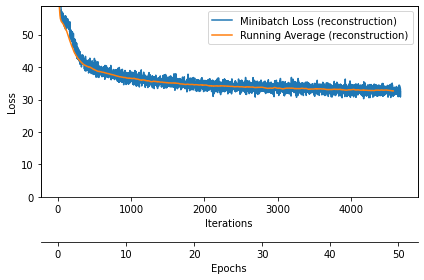

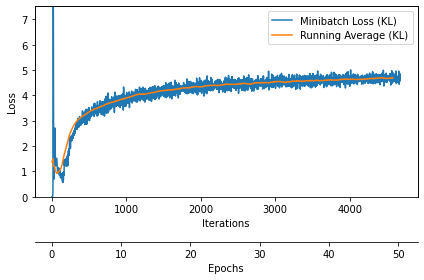

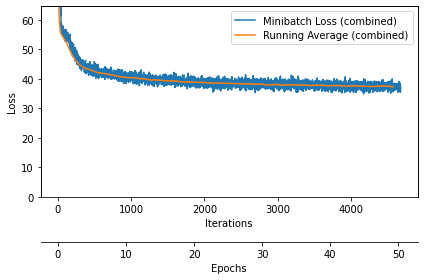

In [15]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], 50, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], 50, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], 50, custom_label=" (combined)")
plt.show()

###Generate Images

In [8]:
def plot_generated_images(data_loader, model, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            
        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i]      
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

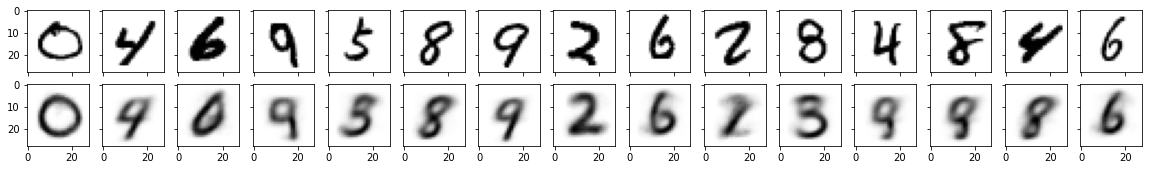

In [26]:
plot_generated_images(data_loader=train_loader, model=model) 

#Images are very blurry because our encoded outputs a 2-dimensional image. that is 
#we are condesing a lot of info into a very small dimension.
#hence recreating it from such a less amount of info is always challenging.
#It leads to some mistakes as well.

###Latent Space

In [9]:
def plot_latent_space_with_labels(num_classes, data_loader, encoding_fn):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):
            
            embedding = encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask])

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

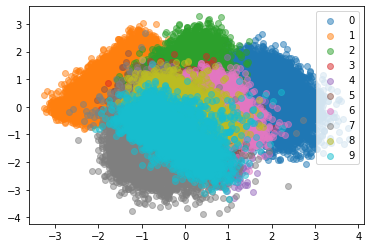

In [51]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn)

plt.legend()
plt.show()

###Generating image for a given point

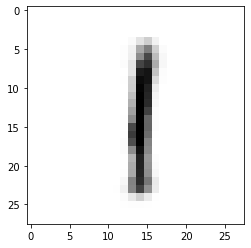

In [54]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-3.0, 0.0]))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image, cmap='binary')
plt.show()

##Increasing encoder output dimension

In [18]:
class Reshape(nn.Module):
  def __init__(self,*args):
    super().__init__()
    self.shape=args
  
  def forward(self,x):
    #print(x.shape)
    return x.view(self.shape)


class Trim(nn.Module):
  def __init__(self,*args):
    super().__init__()
  
  def forward(self,x):
    return x[:,:,:28,:28]


class VAE_v2(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1,32,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.Flatten(),
    )

    self.z_mean = nn.Linear(3136,4)
    self.z_log_var = nn.Linear(3136,4)

    self.decoder = nn.Sequential(
        nn.Linear(4,3136),
        Reshape(-1,64,7,7),
        nn.ConvTranspose2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64,32,stride=(2,2),kernel_size=(3,3),padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32,1,stride=(1,1),kernel_size=(3,3),padding=0),
        Trim(), # 1 x 29 x 29 -> 1x28x28
        nn.Sigmoid() 
    )

  #Used while plotting latent spaces
  def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparametrize(z_mean, z_log_var)
        return encoded
  
  def reparametrize(self, z_mu,z_log_var):
    eps = torch.randn(z_mu.size(0),z_mu.size(1)).to(z_mu)
    z = z_mu + eps * torch.exp(z_log_var/2.)
    return z

  def forward(self,x):
    x = self.encoder(x)
    z_mean,z_log_var = self.z_mean(x),self.z_log_var(x)
    encoded = self.reparametrize(z_mean,z_log_var)
    #print(encoded.shape)
    decoded = self.decoder(encoded)
    return encoded, z_mean, z_log_var, decoded




In [19]:
model = VAE_v2()

In [20]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

In [21]:
log_dict = train_vae(num_epochs=7, model=model, 
                        optimizer=optimizer, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/007 | Batch 0000/0234 | Loss: 224.1050
Epoch: 001/007 | Batch 0050/0234 | Loss: 56.7571
Epoch: 001/007 | Batch 0100/0234 | Loss: 53.0451
Epoch: 001/007 | Batch 0150/0234 | Loss: 50.6079
Epoch: 001/007 | Batch 0200/0234 | Loss: 46.2529
Epoch: 002/007 | Batch 0000/0234 | Loss: 42.5534
Epoch: 002/007 | Batch 0050/0234 | Loss: 41.8111
Epoch: 002/007 | Batch 0100/0234 | Loss: 39.1878
Epoch: 002/007 | Batch 0150/0234 | Loss: 38.3300
Epoch: 002/007 | Batch 0200/0234 | Loss: 37.5832
Epoch: 003/007 | Batch 0000/0234 | Loss: 35.4457
Epoch: 003/007 | Batch 0050/0234 | Loss: 36.4497
Epoch: 003/007 | Batch 0100/0234 | Loss: 36.9699
Epoch: 003/007 | Batch 0150/0234 | Loss: 36.7363
Epoch: 003/007 | Batch 0200/0234 | Loss: 36.8294
Epoch: 004/007 | Batch 0000/0234 | Loss: 33.5447
Epoch: 004/007 | Batch 0050/0234 | Loss: 36.8370
Epoch: 004/007 | Batch 0100/0234 | Loss: 34.7759
Epoch: 004/007 | Batch 0150/0234 | Loss: 35.6107
Epoch: 004/007 | Batch 0200/0234 | Loss: 35.3759
Epoch: 005/007 | Ba

In [22]:
torch.save(model, 'VAEWith4OutputDimension.pth')

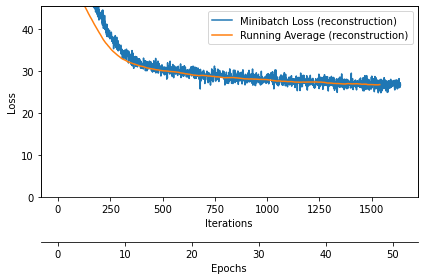

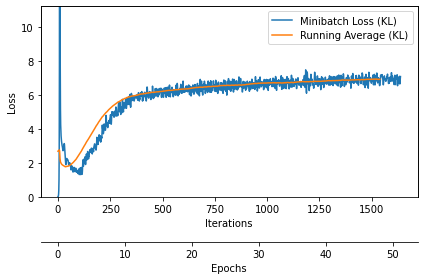

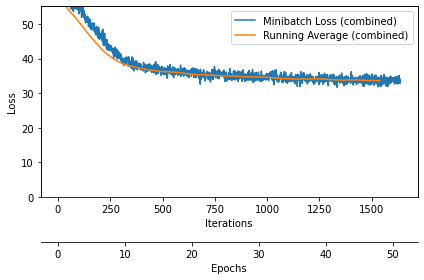

In [23]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], 50, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], 50, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], 50, custom_label=" (combined)")
plt.show()

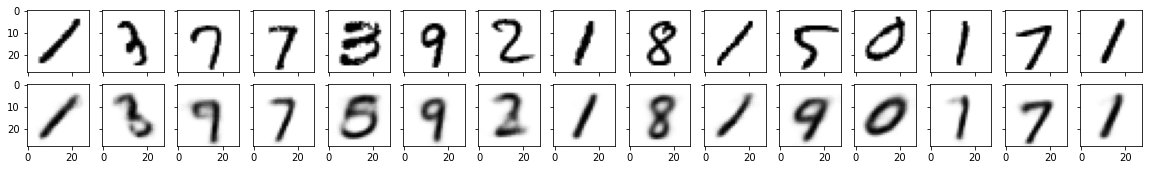

In [24]:
plot_generated_images(data_loader=train_loader, model=model)

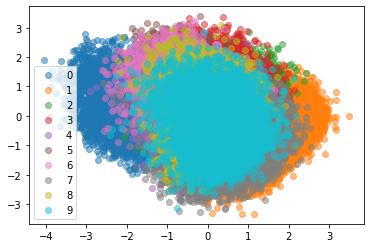

In [25]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=train_loader,
    encoding_fn=model.encoding_fn)

plt.legend()
plt.show()

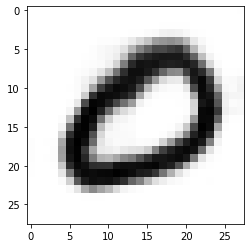

In [27]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([-3.0, 0.0,0.0,1]))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image, cmap='binary')
plt.show()

###Rough Work

In [1]:
64*7*7

3136

In [72]:
3126 * 256

800256

In [36]:
for batch_idx, data in enumerate(train_loader, 0):
    x, y = data 

In [38]:
x.shape

torch.Size([256, 1, 28, 28])

In [39]:
model(x)

RuntimeError: ignored

In [46]:
inp1 =  nn.Conv2d(1,32,stride=(1,1),kernel_size=(3,3),padding=1)(x)
inp1 = nn.LeakyReLU(0.01)(inp1)
inp1 = nn.Conv2d(32,64,stride=(2,2),kernel_size=(3,3),padding=1)(inp1)
inp1 = nn.LeakyReLU(0.01)(inp1)
inp1 = nn.Conv2d(64,64,stride=(2,2),kernel_size=(3,3),padding=1)(inp1)
inp1 = nn.LeakyReLU(0.01)(inp1)
inp1 = nn.Conv2d(64,64,stride=(1,1),kernel_size=(3,3),padding=1)(inp1)
inp1 = nn.Flatten()(inp1)


In [47]:
inp1.shape

torch.Size([256, 3136])

In [54]:
z_mean = nn.Linear(3136,2)(inp1)
z_log_var = nn.Linear(3136,2)(inp1)

In [55]:
z_mean.shape

torch.Size([256, 2])

In [56]:
z_log_var.shape

torch.Size([256, 2])

In [57]:
def reparametrize(z_mu,z_log_var):
  eps = torch.randn(z_mu.size(0),z_mu.size(1)).to(z_mu)
  z = z_mu + eps * torch.exp(z_log_var/2.)
  return z

In [59]:
enc = reparametrize(z_mean, z_log_var)

In [60]:
 enc.shape

torch.Size([256, 2])

In [61]:
dec1 = nn.Linear(2, 3136)(enc)

In [62]:
dec1.shape

torch.Size([256, 3136])

In [63]:
shape = [-1, 64, 7, 7]

In [65]:
dec1.view(shape)

tensor([[[[-6.6561e-01, -9.2277e-01, -1.0816e-01,  ..., -5.7430e-01,
            7.4526e-01,  6.3361e-01],
          [-1.8902e-01, -2.7559e-01,  5.2629e-01,  ...,  7.0483e-01,
           -1.0327e-01,  9.0930e-01],
          [-7.0909e-02, -6.0653e-01,  1.5071e+00,  ..., -5.1390e-01,
           -1.9364e-01,  4.7171e-01],
          ...,
          [ 2.3707e-01,  7.3098e-01, -2.8795e-01,  ..., -1.1339e+00,
           -1.3055e-01,  1.7468e-01],
          [ 7.8601e-02, -3.8716e-01, -7.6305e-01,  ...,  5.7785e-03,
            4.4899e-01,  6.4762e-01],
          [-9.0008e-01, -4.2228e-01, -4.9194e-01,  ..., -1.2204e+00,
           -5.3831e-01,  1.0589e+00]],

         [[ 1.4257e-01, -9.5441e-02,  1.2768e+00,  ..., -2.3836e-01,
            8.3524e-02, -6.7302e-01],
          [ 9.8404e-01,  4.8722e-01, -4.9471e-01,  ..., -1.1588e+00,
           -4.3309e-01, -4.6097e-01],
          [-5.4155e-01,  9.5949e-01, -6.4274e-01,  ...,  1.3701e+00,
           -3.5711e-01,  1.1010e+00],
          ...,
     